In [1]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.plot import pltOL

from utils import seed_everything

torch.manual_seed(0);

In [2]:
syst = psl.systems['LinearSimpleSingleZone']()

In [3]:
import numpy as np
np.random.randint(2)

0

In [4]:
syst = psl.systems['LinearSimpleSingleZone'](seed=0)

nsim = 1

input_x = syst.get_x0()
input_u = syst.get_U(nsim+1)[0].reshape(1,1)
input_d = syst.get_D(nsim)

print("input x : ",input_x)
print("input u : ",input_u)
print("input d : ", input_d)

# simulate the building model over 1000 timesteps

sim = syst.simulate(nsim=nsim, x0=input_x, U=input_u, D=input_d)
print(sim)



input x :  [22.423323 20.345379 17.995863 20.94681 ]
input u :  [[2500.]]
input d :  [[  9.514007 500.       991.16547 ]]
{'X': array([[22.417028, 20.350225, 17.858315, 22.129265]], dtype=float32), 'Y': array([[22.129265]], dtype=float32), 'U': array([], shape=(0, 1), dtype=float32), 'D': array([], shape=(0, 1), dtype=float32), 'Dhidden': array([], shape=(0, 3), dtype=float32), 'Time': array([0.01])}


In [5]:
input_u.shape

(1, 1)

In [22]:
from env import SimpleBuildingEnv

env = SimpleBuildingEnv(simulator=syst, random_seed=10, min_temp=19, max_temp=20)
obs = env.reset()
history = {"obs":[], "action":[], "reward":[], "cost":[], "next_obs":[], "output":[]}
for _ in range(2000):
    action = np.random.randint(2000)
    action = np.array(action).reshape(1,1)
    next_obs, reward, cost = env.step(action,None)
    history["obs"].append(obs)
    history["action"].append(action)
    history["reward"].append(reward)
    history["cost"].append(cost)
    history["next_obs"].append(next_obs)
    history["output"].append(env.y)
    obs = next_obs
#     
    

In [31]:
x_min = 18.
x_max = 22.
#  sampled references for training the policy
list_xmin = [x_min+(x_max-x_min)*np.random.rand()*torch.ones(1, 2)
              for k in range(3)]

In [41]:
np.random.rand()

0.5069329711177959

In [52]:
history["reward"][:3]

[array([[-15.15]]), array([[-64.98]]), array([[-134.34]])]

In [53]:
history["action"][:3]


[1515, 1968, 694]

In [54]:
history["cost"][:3]


[array([[0.81379146]]), array([[0.30746476]]), array([[0.]])]

In [55]:
history["output"][:3]


[array([[20.81379146]]), array([[20.30746476]]), array([[19.67193223]])]

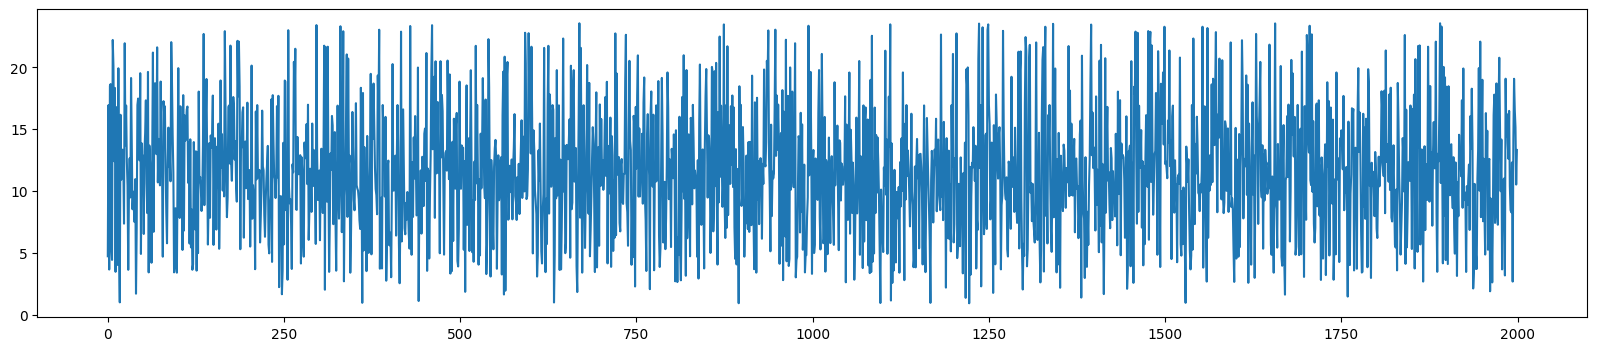

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
plt.plot([ i[6] for i in history["obs"] ])

In [15]:
i

NameError: name 'i' is not defined

In [17]:
history["obs"]

[]

In [25]:
obs

[20.150357746143964,
 19.727185243187986,
 11.796806668896672,
 20.65323042253941,
 19,
 20,
 13.574431,
 500.0,
 831.5236]